In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr
from datetime import date
import sqlite3
import gc

# read data
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

## read in files
dir = '/content/drive/MyDrive/DS 440/Wildfire Data Dir/Data/'
cnx = sqlite3.connect(dir + 'wildfire_data.sqlite')
cursor = cnx.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='Fires';")
tables = cursor.fetchall()
Fires = pd.read_sql_query("SELECT * FROM 'Fires'", cnx).set_index('FOD_ID')
Fires.drop(columns=['FPA_ID','SOURCE_SYSTEM_TYPE','SOURCE_SYSTEM','NWCG_REPORTING_AGENCY','NWCG_REPORTING_UNIT_ID',\
                    'NWCG_REPORTING_UNIT_NAME','SOURCE_REPORTING_UNIT','SOURCE_REPORTING_UNIT_NAME','LOCAL_FIRE_REPORT_ID',\
                    'LOCAL_INCIDENT_ID','FIRE_CODE','FIRE_NAME','ICS_209_PLUS_INCIDENT_JOIN_ID','ICS_209_PLUS_COMPLEX_JOIN_ID',\
                    'MTBS_ID','MTBS_FIRE_NAME','COMPLEX_NAME','OWNER_DESCR','NWCG_CAUSE_CLASSIFICATION',\
                    'NWCG_CAUSE_AGE_CATEGORY','CONT_TIME','CONT_DATE'],inplace=True) #,'DISCOVERY_TIME'
gc.collect()

Mounted at /content/drive


0

In [ ]:
Fires = Fires[Fires['FIRE_YEAR'] > 2014].copy()
gc.collect()

72

In [ ]:
# extract month from discovery date
def get_first_element(date_list):
  return date_list[0]

Fires['DISCOVERY_DATE'] = Fires['DISCOVERY_DATE'].astype("string")
Fires['DISCOVERY_LIST'] = Fires['DISCOVERY_DATE'].str.split(pat='/')
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_LIST'].map(get_first_element)
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_MONTH'].astype("int64")

# encode causes into integers
Fires['NWCG_GENERAL_CAUSE'] = Fires['NWCG_GENERAL_CAUSE'].astype("string")

# figure out number of days to contain the fire
Fires['DAYS_TO_CONT'] = Fires['CONT_DOY'] - Fires['DISCOVERY_DOY']
##### if it was contained the next year, need to do something about that
def convert_negative_days(day):
  if day < 0:
    return 365 + day
  else:
    return day

Fires['DAYS_TO_CONT'] = Fires['DAYS_TO_CONT'].map(convert_negative_days)

# encode state categories into integers
Fires['STATE'] = Fires['STATE'].astype("string")

# fill NA with mean of day to containment (mean = 0.92)
Fires['DAYS_TO_CONT'].fillna(value=Fires['DAYS_TO_CONT'].mean(),inplace=True)

#'DISCOVERY_LIST',
# drop date and list
Fires.drop(columns=['DISCOVERY_DATE','CONT_DOY','DISCOVERY_DOY','FIPS_NAME',\
                    'COUNTY','FIPS_CODE'],inplace=True)
gc.collect()

19

# Downloading Weather Data

In [ ]:
def get_weather_data(lat_min,lat_max,lon_min,lon_max,varname):

  #============================
  # General Settings
  #============================

  # enter your bounding lat/lon for data extraction
  latbounds = [41, 44]
  lonbounds = [75, 80]

  # enter your time start and time end
  year_start = 2014
  year_end = 2018
  month_start=1
  month_end=12

  # enter opendap filename
  pathname = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_terraclimate_' + varname + '_1958_CurrentYear_GLOBE.nc'
  filehandle = Dataset(pathname,'r',format="NETCDF4")

  # enter variable name in the above opendap file
  #varname = 'aet'

  #============================
  # Data Subsetting 
  #============================

  # subset in space (lat/lon)
  lathandle = filehandle.variables['lat']
  lonhandle = filehandle.variables['lon']
  lat=lathandle[:]
  lon=lonhandle[:]

  # find indices of target lat/lon/day
  # find min/max lat/lon
  #lat_min = Fires['LATITUDE'].min()
  #lat_max = Fires['LATITUDE'].max()
  #lon_min = Fires['LONGITUDE'].min()
  #lon_max = Fires['LONGITUDE'].max()
  lat_index_min = (np.abs(lat-lat_min)).argmin()
  lat_index_max = (np.abs(lat-lat_max)).argmin()
  lon_index_min = (np.abs(lon-lon_min)).argmin()
  lon_index_max = (np.abs(lon-lon_max)).argmin()

  def check_latlon_bounds(lat,lon,lat_index,lon_index,lat_target,lon_target):  
      #check final indices are in right bounds
      if(lat[lat_index]>lat_target):   
          if(lat_index!=0):
              lat_index = lat_index - 1
      if(lat[lat_index]<lat_target):
          if(lat_index!=len(lat)):
              lat_index = lat_index +1
      if(lon[lon_index]>lon_target):
          if(lon_index!=0):
              lon_index = lon_index - 1
      if(lon[lon_index]<lon_target):
          if(lon_index!=len(lon)):
              lon_index = lon_index + 1

      return [lat_index, lon_index]

  [lat_index_min,lon_index_min] = check_latlon_bounds(lat, lon, lat_index_min, lon_index_min, lat_min, lon_min)   
  [lat_index_max,lon_index_max] = check_latlon_bounds(lat, lon, lat_index_max, lon_index_max, lon_max, lon_max)

  if(lat_index_min>lat_index_max):
      lat_index_range = range(lat_index_max, lat_index_min+1)
  else:
      lat_index_range = range(lat_index_min, lat_index_max+1)
  if(lon_index_min>lon_index_max):
      lon_index_range = range(lon_index_max, lon_index_min+1)
  else:
      lon_index_range = range(lon_index_min, lon_index_max+1)
      
  lat=lat[lat_index_range]
  lon=lon[lon_index_range]

  #============================
  # subset in time
  timehandle=filehandle.variables['time']
  time=timehandle[:]
  time_min = (date(year_start,month_start,1)-date(1900,1,1)).days
  time_max = (date(year_end,month_end,1)-date(1900,1,1)).days 
  time_index_min = (np.abs(time-time_min)).argmin()
  time_index_max = (np.abs(time-time_max)).argmin()
  time_index_range = range(time_index_min, time_index_max+1)
  time = timehandle[time_index_range]

  #============================
  # subset data
  datahandle = filehandle.variables[varname]
  data = datahandle[time_index_range,lat_index_range,lon_index_range]
  #print(type(data))
  return(data)

In [ ]:
states_with_most_fires = list(Fires.groupby(by='STATE').size().sort_values(ascending=False)[:12].index)

variables = ['aet','pet','soil','PDSI','def', 'ppt', 'q', 'tmax', 'tmin', 'vap', 'ws', 'vpd', 'srad', 'swe']
dct = dict()

for state in states_with_most_fires:
  print(state)

  # subset data by state
  dct[state] = Fires[Fires['STATE'] == state].copy()
  dct[state].reset_index(inplace=True)

  month = list(dct[state].columns).index('DISCOVERY_MONTH')
  year = list(dct[state].columns).index('FIRE_YEAR')
  lat = list(dct[state].columns).index('LATITUDE')
  lon = list(dct[state].columns).index('LONGITUDE')

    # get data for variable and state
  lat_min = dct[state]['LATITUDE'].min()
  lat_max = dct[state]['LATITUDE'].max()
  lon_min = dct[state]['LONGITUDE'].min()
  lon_max = dct[state]['LONGITUDE'].max()
  lat_range = lat_max - lat_min
  lon_range = lon_max - lon_min

  for var in variables:
    print(var)
    masked_state_data = get_weather_data(lat_min,lat_max,lon_min,lon_max,var)

    # init array to store data
    weather_array = np.zeros(len(dct[state]))

    # determine size of arrary
    lon_size = masked_state_data.data.shape[2]
    lat_size = masked_state_data.data.shape[1]

    for i, row in enumerate(dct[state].values):
      if i % 100 == 0:
        pass
        #print(i, var, state)
        #print(row[lon])

      # data indexing
      fire_time_index = (int(row[month]) + 12 * (int(row[year]) - 2014)) - 1
      fire_lat_index = (row[lat] - lat_min) / lat_size
      fire_lon_index = (row[lon] - lon_min) / lon_size
      #print(i,fire_time_index,fire_lat_index,fire_lon_index,int(row[lon]))
      #print(i,row[lon],lon_min)
      point = masked_state_data.data[fire_time_index][int(fire_lat_index)][int(fire_lon_index)]
      weather_array[i] = point

    # add weather array to dataframe
    dct[state][var] = weather_array

CA
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
TX
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
AZ
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
CO
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
NY
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
KS
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
NC
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
GA
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
FL
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
OR
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
MT
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe
AL
aet
pet
soil
PDSI
def
ppt
q
tmax
tmin
vap
ws
vpd
srad
swe


In [ ]:
for state in states_with_most_fires: #
  #['CA', 'TX', 'AZ', 'CO', 'NY', 'KS']: #states_with_most_fires:
  # download data for state
  #'OR', 'MT', 'AL'
  path = '/content/drive/MyDrive/DS 440/Final Report/Data/Big' + state + '.csv'
  dct[state].to_csv(path) #Fires[Fires['STATE'] == state].to_csv(path)

In [ ]:
list(Fires.groupby(by='STATE').size().sort_values(ascending=False)[:12].index)

['CA', 'TX', 'AZ', 'CO', 'NY', 'KS', 'NC', 'GA', 'FL', 'OR', 'MT', 'AL']

In [ ]:
dct['CA'].columns

Index(['FOD_ID', 'FIRE_YEAR', 'DISCOVERY_TIME', 'NWCG_GENERAL_CAUSE',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE',
       'DISCOVERY_LIST', 'DISCOVERY_MONTH', 'DAYS_TO_CONT', 'aet', 'pet',
       'soil', 'PDSI', 'def', 'ppt', 'q', 'tmax', 'tmin', 'vap', 'ws', 'vpd',
       'srad', 'swe'],
      dtype='object')

(array([ 542., 2135., 1216., 1557.,  779.,  342.,  405.,  221.,   44.,
           4.]),
 array([ 0.  ,  8.12, 16.24, 24.36, 32.48, 40.6 , 48.72, 56.84, 64.96,
        73.08, 81.2 ]),
 <a list of 10 Patch objects>)

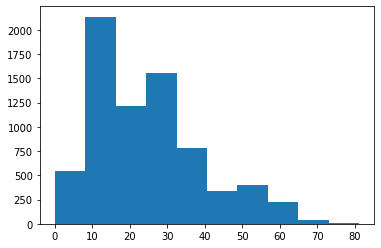

In [ ]:
plt.hist(dct['CA'][(dct['CA']['aet'] < 3276) & (dct['CA']['FIRE_YEAR'] == 2015)]['aet'])
#plt.hist(dct['CA']['aet'])

(array([3142., 1230., 1191., 1309.,  316.,  269.,  117.,   36.,   51.,
          63.]),
 array([ 0.  ,  8.84, 17.68, 26.52, 35.36, 44.2 , 53.04, 61.88, 70.72,
        79.56, 88.4 ]),
 <a list of 10 Patch objects>)

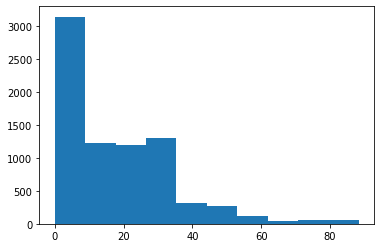

In [ ]:
plt.hist(dct['CA'][(dct['CA']['aet'] < 3276) & (dct['CA']['FIRE_YEAR'] == 2016)]['aet'])